In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import matplotlib.image as mpimg
% matplotlib inline

Goal: quickly and accurately locate a ground control point (GCP) within a subset of a large image, given a small target image which contains the GCP. The large image is 30,000 x 30,000 pixels, with a resolution of 15cm per pixel. The small image is 224 x 224 pixels with the same resolution.

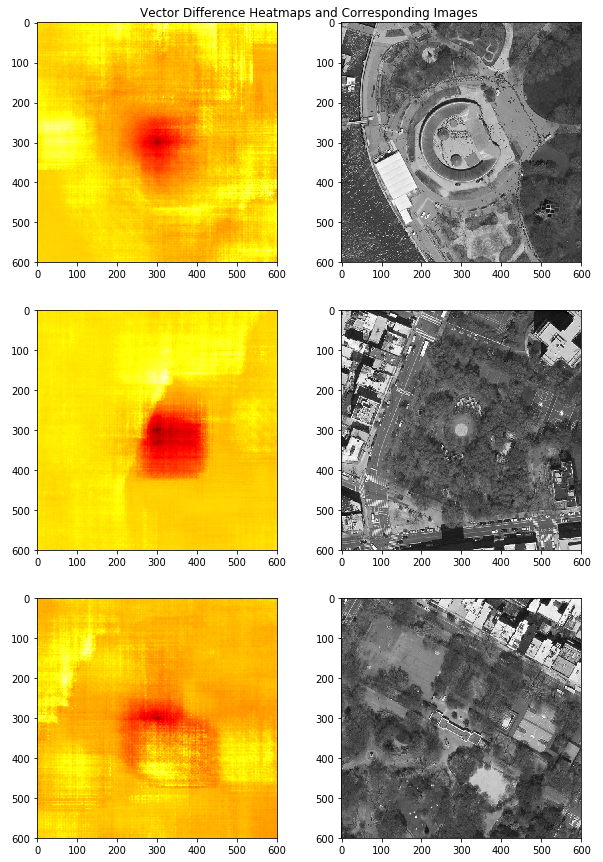

In [23]:
gcp_heatmap_images = ['heatmap_x9204.png', 'gcp_9204.png', 'heatmap_x24343.png',
                      'gcp_24343.png', 'heatmap_x28826.png', 'gcp_28826.png']
fig = plt.figure(figsize=(10, 15))
plt.title('Vector Difference Heatmaps and Corresponding Images')
plt.axis('off')
columns = 2
rows = 3
ax = []
for i in range(columns*rows):
    img = mpimg.imread(gcp_heatmap_images[i])
    ax.append(fig.add_subplot(rows, columns, i+1))
    plt.imshow(img)

plt.show()  

Evaluation: 500 sample monte carlo simulation. Radomly select one of three GCPs. Report x and y position predicted, the rms of the result, and the time to predict.

In [24]:
def mc_simulation(num_trials):
    start = time.time()
    rms_s = []
    pixs = []
    times = []
    gcp = [[9204,18866], [24343, 10582], [28826, 1787]] 
    for i in range(num_trials):
        start = time.time()
        if i % 10 == 0:
            print('MC simulation round:', i)
        rand_idx = np.random.randint(0,3)
        x_pix = gcp[rand_idx: rand_idx + 1][0][0]
        y_pix = gcp[rand_idx: rand_idx + 1][0][1]
        x_pix, y_pix = int(x_pix), int(y_pix)
        if rand_idx == 2: #this is to stay away from the edges
            rand_x_pix = np.random.randint(x_pix - half_est_location, x_pix)
            rand_y_pix = np.random.randint(y_pix, y_pix + half_est_location)
        else:
            rand_x_pix = np.random.randint(x_pix - half_est_location, x_pix + half_est_location)
            rand_y_pix = np.random.randint(y_pix - half_est_location, y_pix + half_est_location)
        x_s, x_f, y_s, y_f = utils.start_lines(rand_x_pix, rand_y_pix, half_est_location)
        t_array = utils.get_img_slice(ny_array, x_pix - half_model_width, y_pix - half_model_width, model_width)
        x_img = image.array_to_img(t_array)
        goal = models.get_pred(x_img)
        try:
            x, y = main_search(ny_array, goal, 40, x_s, y_s, est_location, 1)
            rms = np.sqrt(((x_pix - (x +112))**2) + ((y_pix - (y+112))**2))
            rms_s.append(rms)
            pixs.append([x + 112,y +112])
        except:
            rms_s.append('XXX')
            pixs.append([pix_x, pix_y])
        times.append((time.time()) - start)
    print((time.time()) - start)
    return rms_s, pixs, times
###DO NOT RUN### Supporting code not in this file        
#result, points, times = mc_simulation(500)

Results: The algorithm accurately predicts 96% of the attempts. The failed attempts tend to have a large rms which skews the average rms significantly. The average time to predict was 48 seconds, with many predictions happening around 30 seconds (CPU: Intel Iris Pro 1536 MB). The majority of failures to find the GCP are located at GCP(28826, 1787). 

In [25]:
df = pd.read_csv('search_results15cm.csv')
df.head()

,x,y,result,times
0,9204,18866,0.0,22.935562
1,28826,1787,0.0,90.176239
2,28826,1787,0.0,25.400114
3,24343,10582,0.0,52.636298
4,9204,18866,0.0,29.176277


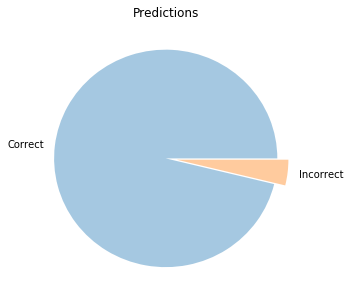

In [26]:
data = [len(df.query('result==0')), len(df.query('result>0'))]
fig = plt.figure(figsize =(5, 5))
explode = (0, 0.1)
p = plt.pie(data, labels = ['Correct', 'Incorrect'], explode = explode)
for i in range(0, 2):
    p[0][i].set_alpha(.4)
plt.title('Predictions')
plt.show()

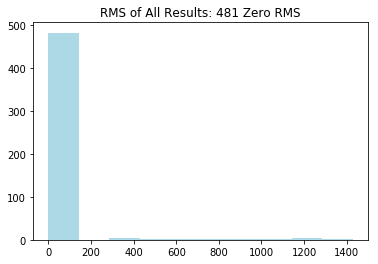

In [27]:
plt.title('RMS of All Results: {} Zero RMS' .format(len(df.query('result == 0')['result'])))
plt.hist(df.result, color = 'lightblue');

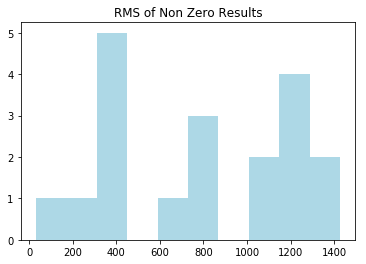

In [28]:
plt.title('RMS of Non Zero Results')
plt.hist(df.query('result > 0')['result'], color = 'lightblue');

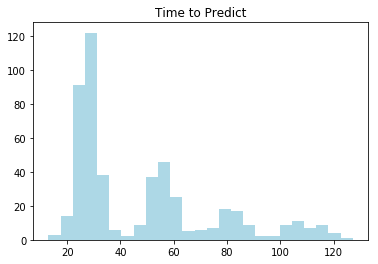

In [29]:
plt.title('Time to Predict')
plt.hist(df.times, color = 'lightblue', bins = 25);

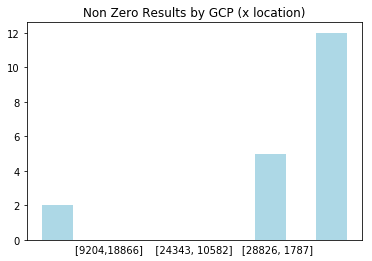

In [30]:
not_zero_df = df.query('result>0')
non_zero_len = len(not_zero_df)
plt.xticks([])
plt.xlabel('[9204,18866]    [24343, 10582]   [28826, 1787]')
plt.title('Non Zero Results by GCP (x location)' .format(non_zero_len))
plt.hist(not_zero_df.x, color = 'lightblue');

Conclusions: When the algorithm gets it right, it does a really good job. When it gets it wrong, it is terribly wrong. Most of the failures to predict are clustered in the GCP(28826, 1787). Further exploration of that set of data points may be warrated. The first stage of the algorithm is a random search, as such the results tend to be random (although it works most of the time). This first stage may be able to be refined to provide a more reliable indication of a region of interest. Additionally, it may be possible to reframe this problem as a DQNN reinforcement learning problem, let the code figure out the best way to search. The good part about the current algorithm is there is no training, it should be able to predict any set of points on the image. The bad part is, due to the varying nature of images in the wild (perspective, illumination, etc.) I doubt it will perform as well as it has. Going forward, it may be useful to reduce the images to 'major features', then align the images in a similar fashion to the current algorithm. 